# Лабораторные   работы   1-2 
# «Разработка   рекомендательного   сервиса» 

Выполнил: xxx xxx xxxович, Группа xxx, вариант 5

Цель работы:
 1. Изучить возможности процедур работы с данными с использованием языка разработки Python 
 2. Разработать элементы функций рекомендательного сервиса на основе метода коллаборативной фильтрации 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#pretty plots
import seaborn as sns
plt.style.use('seaborn')

#for good visualisation in notebook
from IPython.core.display import display, HTML, Markdown

# Progress bar for a “for” loop
from tqdm.notebook import tqdm

## Первичное знакомство с данными

### Metadata
- reviewerID - ID of the reviewer, e.g. A2SUAM1J3GNN3B
- asin - ID of the product, e.g. 0000013714   https://www.amazon.com/dp/0000013714
- reviewerName - name of the reviewer
- helpful - helpfulness rating of the review, e.g. 2/3
- reviewText - text of the review
- overall - rating of the product
- summary - summary of the review
- unixReviewTime - time of the review (unix time)
- reviewTime - time of the review (raw)

In [2]:
df = pd.read_csv("datasets/05.Amazon_Automotive/05.Amazon Automotive.csv")
display(df.head())
display(df.shape)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A3F73SC1LY51OO,B00002243X,Alan Montgomery,"[4, 4]",I needed a set of jumper cables for my new car...,5,Work Well - Should Have Bought Longer Ones,1313539200,"08 17, 2011"
1,A20S66SKYXULG2,B00002243X,alphonse,"[1, 1]","These long cables work fine for my truck, but ...",4,Okay long cables,1315094400,"09 4, 2011"
2,A2I8LFSN2IS5EO,B00002243X,Chris,"[0, 0]",Can't comment much on these since they have no...,5,Looks and feels heavy Duty,1374710400,"07 25, 2013"
3,A3GT2EWQSO45ZG,B00002243X,DeusEx,"[19, 19]",I absolutley love Amazon!!! For the price of ...,5,Excellent choice for Jumper Cables!!!,1292889600,"12 21, 2010"
4,A3ESWJPAVRPWB4,B00002243X,E. Hernandez,"[0, 0]",I purchased the 12' feet long cable set and th...,5,"Excellent, High Quality Starter Cables",1341360000,"07 4, 2012"


(20473, 9)

In [3]:
for col in df.columns:
    display(HTML('<h1 style="background-color:#FFAA00;">' + col + '</h1>'))
    display(df[col].describe())

count              20473
unique              2928
top       A2V1J3JT5OOZFO
freq                  51
Name: reviewerID, dtype: object

count          20473
unique          1835
top       B000CITK8S
freq             169
Name: asin, dtype: object

count               20260
unique               2788
top       Amazon Customer
freq                  173
Name: reviewerName, dtype: object

count      20473
unique       380
top       [0, 0]
freq       12844
Name: helpful, dtype: object

count                                                 20467
unique                                                20467
top       They fit tight and look good but once you go t...
freq                                                      1
Name: reviewText, dtype: object

count    20473.000000
mean         4.471841
std          0.940337
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: overall, dtype: float64

count          20473
unique         17225
top       Five Stars
freq              95
Name: summary, dtype: object

count    2.047300e+04
mean     1.365018e+09
std      3.621266e+07
min      1.121386e+09
25%      1.354838e+09
50%      1.373414e+09
75%      1.390435e+09
max      1.405901e+09
Name: unixReviewTime, dtype: float64

count          20473
unique          1855
top       07 8, 2014
freq              82
Name: reviewTime, dtype: object

---
Для дальнейшей работы нам потребуются только "reviewerID", "asin" и "overall", причём, переименуем их сразу в "user", "item" и "rating"

In [4]:
df = df[["reviewerID", "asin", "overall"]]
df.columns = ["user", "item", "rating"]
df.head()

,user,item,rating
0,A3F73SC1LY51OO,B00002243X,5
1,A20S66SKYXULG2,B00002243X,4
2,A2I8LFSN2IS5EO,B00002243X,5
3,A3GT2EWQSO45ZG,B00002243X,5
4,A3ESWJPAVRPWB4,B00002243X,5


In [5]:
def shortDescriptionOfFilling(rankings: pd.DataFrame):
    n_users = len(rankings["user"].unique())
    n_items = len(rankings["item"].unique())
    n_ratings = len(rankings)
    print ("Унакальных Пользователей:", n_users)
    print ("Унакальных Товаров:", n_items)
    print ("Выставленных оценок:", n_ratings)
    # Расчет доли заполнения оценками
    print("Размер матрицы: {} x {}, Ячеек в матрице: {}, Заполнено: {:.3%}".format (n_users, n_items, n_users * n_items, n_ratings / (n_users * n_items)))

In [6]:
shortDescriptionOfFilling(df)

Унакальных Пользователей: 2928
Унакальных Товаров: 1835
Выставленных оценок: 20473
Размер матрицы: 2928 x 1835, Ячеек в матрице: 5372880, Заполнено: 0.381%


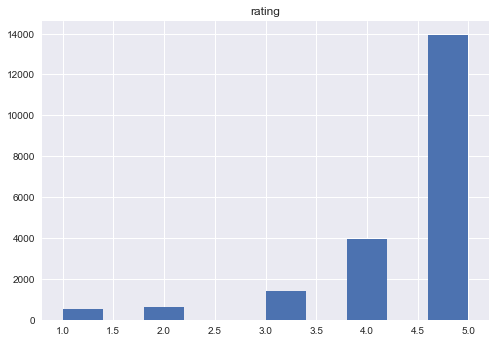

In [7]:
df.hist()
plt.show()

Большинство из выставленных оценок - это "5". Плохие оценки люди выставляют очень редко. Также замечено, что не существует оценок "0".

## Выбор части исходной таблицы с пользователями, имеющими наибольшее кол-во оценок

Изначальная заполненность таблицы очень маленькая. Из всех пользователей и фильмов выберем **n_users** пользователей с наибольшим кол-вом отзывов и из них **n_items** объектов с наибольшим кол-вом отзывов.

In [8]:
nUsers = 20
nItems = 28

mostActiveUsers = (df["user"].value_counts()[:nUsers]).index.tolist()
mostActiveUsers.sort()
dfNUsers = df[df["user"].isin(mostActiveUsers)]
mostActiveItems = (dfNUsers["item"].value_counts()[:nItems]).index.tolist()
mostActiveItems.sort()
rankings = dfNUsers[dfNUsers["item"].isin(mostActiveItems)].reset_index(drop=True)

print("Было", len(df), "элементов в DataFrame")
print("Стало", len(rankings), "элементов в DataFrame")
print("-"*40)
display(Markdown("**Полученная таблица с наибольшим количеством отзывов:**"))
# display(rankings.head(3))
shortDescriptionOfFilling(rankings)

Было 20473 элементов в DataFrame
Стало 95 элементов в DataFrame
----------------------------------------


**Полученная таблица с наибольшим количеством отзывов:**

Унакальных Пользователей: 20
Унакальных Товаров: 28
Выставленных оценок: 95
Размер матрицы: 20 x 28, Ячеек в матрице: 560, Заполнено: 16.964%


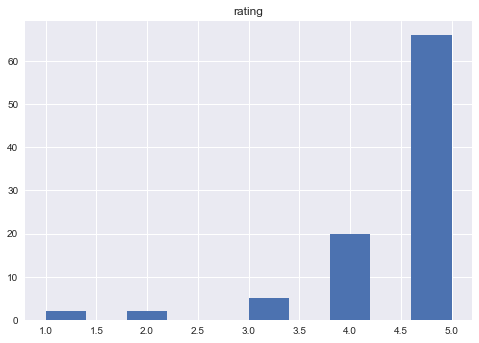

5    66
4    20
3     5
2     2
1     2
Name: rating, dtype: int64


In [9]:
rankings.hist()
plt.show()
print(rankings["rating"].value_counts())

## Получение списка уникальных пользователей и товаров

In [10]:
userUniqList=rankings["user"].unique().tolist()
userUniqList.sort()
itemUniqList=rankings["item"].unique().tolist()
itemUniqList.sort()

## Формирование матрицы R

In [11]:
def createR(rankings: pd.DataFrame, userUniqList: list, itemUniqList: list) -> np.ndarray :
    # Создание матрицы нужной размерности
    R = np.zeros((len(userUniqList), len(itemUniqList)))

    # Занесение оценок в матрицу
    for i in tqdm(rankings.index) :
        line = rankings.loc[i, :]
        userName = line["user"]
        itemName = line["item"]
        rate = float(line["rating"])
        # получить индекс ИД_пользователя/предмета в списке уникальных ИД
        indexForUser = userUniqList.index(userName)
        indexForItem = itemUniqList.index(itemName)
        # Внести оценку
        R[indexForUser, indexForItem] = rate
    return R

In [12]:
R = createR(rankings, userUniqList, itemUniqList)

In [13]:
# Расчет доли заполнения оценками
print("Размер матрицы {} x {}, Элементов {}, Заполнено {:%}".format (
    R.shape[0], R.shape[1],
    R.shape[0] * R.shape[1],
    len (rankings)/(R.shape[0] * R.shape[1])))

Размер матрицы 20 x 28, Элементов 560, Заполнено 16.964286%


## Вывод матрицы R в графическом виде

In [14]:
from matplotlib import cm # Вывод матрицы R в графическом виде

def visualizeR(R: np.ndarray, xlabel: str, ylabel: str, xlabelsList=None, 
               ylabelsList=None, isAddTicks=False, autoFigsize=True):
    R = R.round().astype('int8') 
    # создание своей цветовой карты, с разделением на 6 участков по количеству оценок (включая 0)
    myColorMap = cm.get_cmap('viridis', 6)
    # создание полотна размером HхW
    if autoFigsize:
        plt.figure(figsize=(9, 6.5))
    # отрисовка матрицы, применив цветовую карту
    plt.imshow(R, myColorMap)
    # добавление названия осей
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    # добавление подписи осей
    if isAddTicks:
        plt.xticks( ticks=np.arange(len(xlabelsList)),
                    labels=xlabelsList,
                    rotation=20)
        plt.yticks( ticks=np.arange(len(ylabelsList)),
                    labels=ylabelsList,
                    rotation=0)
    else:
        if(xlabelsList is not None):
            plt.xticks(ticks=np.arange(0,len (xlabelsList)), labels=[])
        else:
            plt.xticks(ticks=[], labels=[])
        if(xlabelsList is not None):
            plt.yticks(ticks=np.arange(0,len (ylabelsList)), labels=[])
        else:
            plt.yticks(ticks=[], labels=[])
    # добавление цветовой полосы
    plt.colorbar()

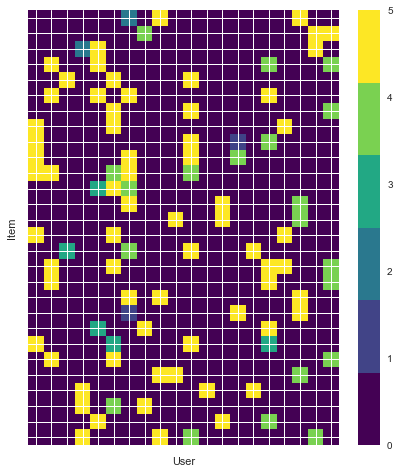

In [15]:
# visualizeR(R, "Item", "User", itemUniqList, userUniqList)

# Транспонированная матрица R
plt.figure(figsize=(7, 8))
visualizeR(R.T, "User", "Item", userUniqList, itemUniqList, autoFigsize=False)

# Отыскание похожих пользователей

В задании указывали, что функция схожести вычисляется только по тем объектам, которые оценили оба пользователя. Функция notUseZero позволяет учесть этот момент.

In [16]:
def notUseZero(x: np.array, y: np.array):
    if (type(x) is not np.ndarray or type(y) is not np.ndarray):
        x = np.array(x)
        y = np.array(y)
    else:
        x = x.copy()
        y = y.copy()
    y[x == 0] = 0
    x[y == 0] = 0
    return x, y

def test_notUseZero():
    x = [1, 2, 0, 0]
    y = [0, 3, 0, 1]
    xExpected = [0, 2, 0, 0]
    yExpected = [0, 3, 0, 0]
    xReceived, yReceived = notUseZero(x, y)
    assert (xExpected == xReceived).all(),\
            "X failed.\n\tExpected: {}\n\tReceived: {}".format(xExpected, xReceived)
    assert (yExpected == yReceived).all(),\
            "Y failed.\n\tExpected: {}\n\tReceived: {}".format(yExpected, yReceived)
    print("test_notUseZero выполнен успешно")

test_notUseZero()

test_notUseZero выполнен успешно


## Метрики

In [17]:
def euclideDistance(x: np.array, y: np.array):
    return sum((x - y)**2)**0.5

def manhattanDistance(x: np.array, y: np.array):
    return sum(abs(x - y))

def pearson(x: np.array, y: np.array):
    if ((np.max(x) == np.min(x)) or (np.max(y) == np.min(y))): # Один из векторов состоит только из одного значения
        return 0
    if (x == y).all():
        return 1
    return sum((x - x.mean()) * (y - y.mean())) / (sum(x**2 - x.mean()**2)**0.5 * sum(y**2 - y.mean()**2)**0.5)

def jaccardDistance(x: np.array, y: np.array):
    if (x == y).all():
        return 1
    return sum(np.minimum(x, y)) / sum(np.maximum(x, y))

def cosinusDistance(x: np.array, y: np.array):
    if (x == y).all():
        return 1
    xdoty = x.dot(y)
    if (np.isclose(xdoty, 0)):
        return 0
    return x.dot(y) / (np.linalg.norm(x) * np.linalg.norm(y))
 

In [18]:
def tests_distance():
    # Проверка, на нулевом векторе
    x = np.zeros(5)
    assert np.isclose(euclideDistance(x, x), 0), "euclideDistance, empty"
    assert np.isclose(manhattanDistance(x, x), 0), "manhattanDistance, empty"
    assert np.isclose(pearson(x, x), 0), "pearson, empty"
    assert np.isclose(jaccardDistance(x, x), 1), "jaccardDistance, empty"
    assert np.isclose(cosinusDistance(x, x), 1), "cosinusDistance, empty"
    
    # Теперь то же самое (вектор сам с сабой), но вектор не нулевой
    x = np.random.rand(5)
    assert np.isclose(euclideDistance(x, x), 0), "euclideDistance, вектор сам с сабой"
    assert np.isclose(manhattanDistance(x, x), 0), "manhattanDistance, вектор сам с сабой"
    assert np.isclose(pearson(x, x), 1), "pearson, вектор сам с сабой"
    assert np.isclose(jaccardDistance(x, x), 1), "jaccardDistance, вектор сам с сабой"
    assert np.isclose(cosinusDistance(x, x), 1), "cosinusDistance, вектор сам с сабой"
    
    
    x = np.array([1, 1])
    y = np.array([0, 0])
    assert np.isclose(euclideDistance(x, y), 2**0.5), "euclideDistance, x={}, y={}".format(x, y)
    assert np.isclose(manhattanDistance(x, y), 2), "manhattanDistance, x={}, y={}".format(x, y)
    assert np.isclose(pearson(x, y), 0), "pearson, x={}, y={}".format(x, y)
    assert np.isclose(jaccardDistance(x, y), 0), "jaccardDistance, x={}, y={}".format(x, y)
    assert np.isclose(cosinusDistance(x, y), 0), "cosinusDistance, x={}, y={}".format(x, y)
    
    x = np.array([0, 1])
    y = np.array([1, 0])
    assert np.isclose(euclideDistance(x, y), 2**0.5), "euclideDistance, x={}, y={}".format(x, y)
    assert np.isclose(manhattanDistance(x, y), 2), "manhattanDistance, x={}, y={}".format(x, y)
    assert np.isclose(pearson(x, y), -1), "pearson, x={}, y={}".format(x, y)
    assert np.isclose(jaccardDistance(x, y), 0), "jaccardDistance, x={}, y={}".format(x, y)
    assert np.isclose(cosinusDistance(x, y), 0), "cosinusDistance, x={}, y={}".format(x, y)
    
    print("tests_distance выполнен успешно")
    
tests_distance()

tests_distance выполнен успешно


## Мера схожести sim
Мера схожести равна 0, если объекты не схожи, и положительному числу (желательно 1), если схожи. Соответственно, чем ближе sim к 0, тем менее похожи объекты.

Для меры Евклида и Манхэттенской меры сделали, как рекомендовали в notebook-примере. Для коэффициента корреляции Пирсона оставили, значение для положительной корреляции, для отрицательной - сделали sim=0. Для меры Жаккара можно ни чего не менять, так как у нас оценки положительные, то мера будет в диапазоне [0; 1]. Косинусная мера имеет 1, когда объекты совпадают; когда значения отрицательны, то сделали sim=0.

In [19]:
class Sim(object):
    
    def __init__(self, x: np.array, y: np.array):
        self._x, self._y = notUseZero(x, y)
        if ((self._x == 0).all() or (self._y == 0).all()): # В этом случае для всех способов sim будет 0
            self._sim = 0
        else : # Иначе придётся в дальнейшем вычислять
            self._sim = self.simCalculate(x, y)
        
    @staticmethod
    def simCalculate(x: np.array, y: np.array):
        raise "It's abstract method. You should override it"
      
    @property
    def sim(self):
        return self._sim


In [20]:
class EuclideSim(Sim):
    @staticmethod
    def simCalculate(x: np.array, y: np.array):
        return 1 / (1 + euclideDistance(x, y))
    
    
class ManhattanSim(Sim):
    @staticmethod
    def simCalculate(x: np.array, y: np.array):
        return 1 / (1 + manhattanDistance(x, y))


class PearsonSim(Sim):
    @staticmethod
    def simCalculate(x: np.array, y: np.array):
        s = pearson(x, y)
        s = s if s > 0 else 0
        return s

    
class JaccardSim(Sim):
    @staticmethod
    def simCalculate(x: np.array, y: np.array):
        return jaccardDistance(x, y)
        
class CosinusSim(Sim):
    @staticmethod
    def simCalculate(x: np.array, y: np.array):
        s = cosinusDistance(x, y)
        s = s if s > 0 else 0
        return s

## Получение матрицы RSim
Это будет квадратная, симметричная относительно главной диагонали таблица, в которой показаны sim для каждой пары сравниваемых субъектов/объектов. При этом, по диагонали будут нули (то есть, sim=0 для самого себя).

*(Это немного отличается от пошагового задания, но конечный результат будет одинаковым).*

In [21]:
def getRSim(R, labels: list, SimClass) -> pd.DataFrame:
    """
        R: матрица, строками которой являются сравниваемые объекты
        labels: список имён сравниваемых объектов
    return:
        RSim: квадратная, симметричная относительно главной диагонали таблица, 
              в которой показаны sim для каждой пары сравниваемых объектов. При этом, по диагонали нули 
              (то есть, sim=0 для самого себя)
    """
    RSim = pd.DataFrame(0, columns=labels, index=labels)
    for i in range(len(labels) - 1):
        for j in range(i + 1, len(labels)):
            sim = SimClass(R[i], R[j])
            RSim.iloc[i, j] = sim.sim
    # Заполнили только для верхней части матрицы, теперь надо отразить относительно диагонали
    RSim = RSim + RSim.T
    return RSim

def exampleRSim():
    display(Markdown("**Пример RSim**"))
    R = np.array([np.array([1, 0, 1]), np.array([1, 0, 1]), np.array([1, 0, 0]), np.array([5, 0, 0])])
    print("R:")
    display(R)
    labels = ["q", "w", "r", "t"]
    print("labels: {}".format(labels))
    print("SimClass: ManhattanSim")
    print("RSim:")
    display(getRSim(R, labels, ManhattanSim))
    
exampleRSim()

**Пример RSim**

R:


array([[1, 0, 1],
       [1, 0, 1],
       [1, 0, 0],
       [5, 0, 0]])

labels: ['q', 'w', 'r', 't']
SimClass: ManhattanSim
RSim:


,q,w,r,t
q,0.000000,1.000000,0.5,0.166667
w,1.000000,0.000000,0.5,0.166667
r,0.500000,0.500000,0.0,0.200000
t,0.166667,0.166667,0.2,0.000000


## Получение списка отранжированных k-субъектов/объектов (схожих)

Функция topMatches возвращает список отранжированных k-субъектов/объектов. В работе используется k=5. На входе в функцию передается DataFrame RSim, название субъекта/объекта, для которого происходит ранжирование и k. 

In [22]:
def topMatches(RSim, label, k=5) -> list:
    """
        RSim: смотри getRSim
        label: название субъекта/объекта, для которого происходит ранжирование
        k: количество похожих субъектов/объектов
    return:
        list: не более k наиболее похожих на label субъектов/объектов
    """
    resLabels = RSim.loc[label].sort_values(ascending=False)[:k]
    resLabels = resLabels[resLabels != 0]
    return resLabels.index.tolist()

def exampleTopMatches():
    display(Markdown("**Пример topMatches**"))
    R = np.array([np.array([1, 0, 1]), np.array([1, 0, 1]), np.array([1, 0, 0]), np.array([5, 0, 0])])
    labels = ["q", "w", "r", "t"]
    rsim = getRSim(R, labels, ManhattanSim)
    print("RSim:")
    display(rsim)
    print("topMatches(rsim, \"w\", 2):")
    topMatch = topMatches(rsim, "w", 2)
    print(topMatch)
    print("Values from RSim for topMatches:")
    print(rsim.loc["w", topMatch])
    
exampleTopMatches()

**Пример topMatches**

RSim:


,q,w,r,t
q,0.000000,1.000000,0.5,0.166667
w,1.000000,0.000000,0.5,0.166667
r,0.500000,0.500000,0.0,0.200000
t,0.166667,0.166667,0.2,0.000000


topMatches(rsim, "w", 2):
['q', 'r']
Values from RSim for topMatches:
q    1.0
r    0.5
Name: w, dtype: float64


# Прогноз на объекты без оценки

Реализована функцию getRating, которая прогнозирует оценку пользователя для еще неоцененного им объекта. Функция использует результаты уже реализованной функции topMatches.

Для каждого отдельного нового объекта оценка = сумма взвешенных оценок/ сумму коэфф. схожести тех, кто оценил этот объект


In [23]:
def getRating(R: np.ndarray, RSim: pd.DataFrame, label: list, k=5, verbose=False) -> np.ndarray:
    """
    Считает рейтинг для label.
    return
        RCalculated: посчитанные оценки. При этом, размер массива равен количеству объектов в R. 
                     0 стоит для тех, объектов, для которых не производился расчёт
    """
    topMatch = topMatches(RSim, label, k)
    indexesOfTopMatches = [RSim.columns.get_loc(elem) for elem in topMatch]
    RForLabel = R[RSim.columns.get_loc(label)]
    RCalculated = np.zeros(R.shape[1])
    R = R[indexesOfTopMatches] # Получили оценки только для похожих
    topMatchValues = RSim.loc[label, topMatch]
    
    # При этом, сразу посчитаем их среднее взвешенное, но пока что без нормировки весов. 
    # Теперь вся задача бутет состоять в правильной нормировке, так как если оценка была 0,
    # то это слагаемое надо не учитывать, при нормировании. 
    # нормировка будет состоять в делении полученной ненормированной оценки на сумму 
    # коэффициентов близости субъектов, 
    # для которых оценка не была 0
    RnotNormed = R.T.dot(topMatchValues) # это ненормированное среднее взвешенное

    if (verbose):
        print("Значения близости:", topMatchValues.values)

    # Перебираем по каждому товару (если user-based) / пользователю (если item-based)
    # для которого нет оценки
    for i in np.where(RForLabel == 0)[0]: 
        r = RnotNormed[i]
        indicesForNotZero = np.where(R.T[i] != 0)[0]
        if (len(indicesForNotZero) == 0):
            continue
        r = r / sum(topMatchValues[indicesForNotZero])
        RCalculated[i] = r

        if (verbose):
            display(Markdown("**i = {}**".format(i)))
            print("Это оценки от \"близких\":", R.T[i])
            print("Используем следующие индексы:", indicesForNotZero)
            display(Markdown("Полученная средневзвешенная оценка ***r = {:.2f}***".format(r)))
    return RCalculated


In [24]:
def getRatingsForAll(R: np.ndarray, RSim: pd.DataFrame, k=5, verbose=False) -> np.ndarray:
    """
    Считает рейтинг для всех объектов.
    return
        RCalculated: посчитанные оценки в такой же форме, как и R
    """
    RCalculated = np.zeros_like(R)
    labels = RSim.columns.to_list()
    for i in tqdm(range(len(labels))):
        if verbose :
            display(Markdown("**{}**".format(labels[i])))
        RCalculated[i] = getRating(R, RSim, labels[i], k, verbose)
    return RCalculated

**User-based, ManhattanSim**

Количество предсказаных значений: 226
Количество предсказаных значений, делённое на количество пользователей: 11.30
Количество предсказаных значений, делённое на количество товаров: 8.07


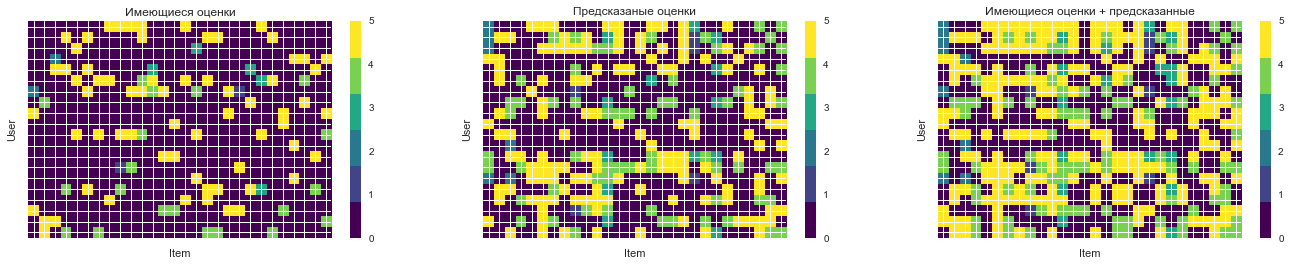

**Item-based, ManhattanSim**

Количество предсказаных значений: 154
Количество предсказаных значений, делённое на количество пользователей: 7.70
Количество предсказаных значений, делённое на количество товаров: 5.50


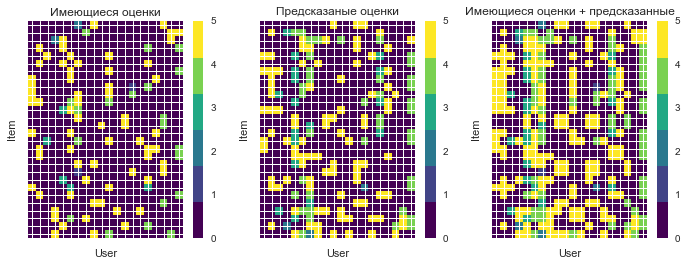

In [25]:
def visualizeRAndRCalculated(R, RCalculated, xTitle, yTitle, 
                             xListLabels, yListLabels, isAddTicks=False):
    fig, axs = plt.subplots(nrows=1, ncols=3,
                            figsize=(3 * 5.5 * R.shape[1] / R.shape[0] + 0, 4))
    plt.sca(axs[0]) 
    visualizeR(R, xTitle, yTitle, xListLabels, yListLabels, autoFigsize=False)
    plt.title("Имеющиеся оценки")

    plt.sca(axs[1]) 
    visualizeR(RCalculated, xTitle, yTitle, xListLabels, yListLabels, autoFigsize=False)
    plt.title("Предсказаные оценки")
    
    plt.sca(axs[2]) 
    visualizeR(R + RCalculated, xTitle, yTitle, xListLabels, yListLabels, autoFigsize=False)
    plt.title("Имеющиеся оценки + предсказанные")
    

usedSim = ManhattanSim

RSim = getRSim(R, userUniqList, usedSim)
RCalculated = getRatingsForAll(R, RSim)

display(Markdown("**User-based, {}**".format(usedSim.__name__)))
print("Количество предсказаных значений: {}".format((RCalculated != 0).sum()))
print("Количество предсказаных значений, делённое на количество пользователей: {:.2f}"\
      .format((RCalculated != 0).sum() / R.shape[0]))
print("Количество предсказаных значений, делённое на количество товаров: {:.2f}"\
      .format((RCalculated != 0).sum() / R.shape[1]))
visualizeRAndRCalculated(R, RCalculated, "Item", "User", itemUniqList, userUniqList)
plt.show()

RSim = getRSim(R.T, itemUniqList, usedSim)
RCalculated = getRatingsForAll(R.T, RSim)
display(Markdown("**Item-based, {}**".format(usedSim.__name__)))
print("Количество предсказаных значений: {}".format((RCalculated != 0).sum()))
print("Количество предсказаных значений, делённое на количество пользователей: {:.2f}"\
      .format((RCalculated != 0).sum() / R.shape[0]))
print("Количество предсказаных значений, делённое на количество товаров: {:.2f}"\
      .format((RCalculated != 0).sum() / R.shape[1]))
visualizeRAndRCalculated(R.T, RCalculated, "User", "Item", userUniqList, itemUniqList)
plt.show()

# Протестировать качество алгоритма коллаборативной фильтрации

Реализована функция calculateError, которая позволяет рассчитать среднеквадратическую ошибку

In [26]:
def calculateError(predict: np.ndarray, actual: np.ndarray):
    if len(predict)!=len(actual):
        raise BaseException("Кол-во элементов не совпадает")
    if type(predict) != np.ndarray or type(actual) != np.ndarray:
        predict = np.array(predict)
        actual = np.array(actual)
    return ((predict - actual)**2).sum()**0.5
    
# ---------------------------------------------------------------------------------

assert np.isclose(calculateError(predict=[1,0,3], actual=[1,2,3]), 2)

## Выбор пользователей и оценок для использования в качестве проверочных

- b. Выбрать несколько (минимум 3-5) оценок из исходной матрицы R для использования в качестве проверочных при расчете среднеквадратической ошибки.
    - i. Выберите субъекта(пользователя), для которого имеется наибольшее количество оценок объектов (при этом оценки должны  быть по объектам у которых есть не менее двух оценок от стороннего субъекта(пользователя).
    - ii. Сохраните в отдельной структуре вектор оценок  выбранного субъекта(пользователя)
    - iii. В исходной матрице R с оценками исключите 25-30%  значений для выбранного субъекта (заменить значение “0”). Если количество оценок мало, допустимо повторить процедуру для нескольких субъектов(пользователя) (Пример: исключить по одной оценке у трех пользователей)

- c. Рассчитайте для новой матрицы с пропущенными значениями  (замененными на “0”) оценки с помощью разработанной рекомендательной системы. При этом убедитесь, что алгоритму достаточно входных данных для расчета. 


Для начала посмотрим количество выставленных оценок по пользователям и по товарам 

In [27]:
def displayDFSideBySide(*args):
    """
    args: pandas.DataFrame objects
    """
    htmlStr=''
    for df in args:
        htmlStr += df.to_html()
        htmlStr += "&nbsp;" * 10
    display(HTML(htmlStr.replace('table','table style="display:inline"')))

# Ритуал с сортировкой требуется, чтобы порядок индексов с одинаковым количеством оценок
# всегда был одинаковым. Без этого разбиения на тренировочную и тестовую выборки 
# всегда будут различны.
# mergesort является стабильной сортировкой
rankingsUserCounts = rankings["user"].value_counts()
rankingsUserCounts = rankingsUserCounts.sort_index()
rankingsUserCounts = rankingsUserCounts.sort_values(kind="mergesort", ascending=False) 
rankingsItemCounts = rankings["item"].value_counts()
rankingsItemCounts = rankingsItemCounts.sort_index()
rankingsItemCounts = rankingsItemCounts.sort_values(kind="mergesort", ascending=False)

display(Markdown("**Количество выставленных оценок по пользователям и по товарам**"))
displayDFSideBySide(rankingsUserCounts.to_frame(), rankingsItemCounts.to_frame())

**Количество выставленных оценок по пользователям и по товарам**

,user
A1N087XH2AUKWP,10
A1P3RTQKM8BRBL,9
AENRE9BP7LJMK,8
A2HMF8ZR67BNZS,8
AZV2U6GU5QA6C,6
ALHWZSTAELK9I,6
A1GGWEX2RW0IRW,6
A195N77NYOW2PO,6
A14Z6D3IRJ23F7,6
A23ONMGKEWDG4M,4


Возьмём из первых 11 пользователей случайным образом (перемешиваем товары внутри выбрвнного пользователя) по 2 оценки

In [28]:
import random

# Использую как счётчики
rankingsUserCountsAfterSplit = rankingsUserCounts.copy()
rankingsItemCountsAfterSplit = rankingsItemCounts.copy()

# В цикле далее из rankingsTrain будем выкидывать значения, 
# которые пойдут в проверочную выборку rankingsTest
rankingsTrain = rankings.copy() 
rankingsTest = pd.DataFrame(columns=rankings.columns) # Пустой, заполняется в цикле далее

random.seed(20201202) # Чтобы результаты перемешивания были воспроизводимы
# Два раза в цикле проходим по первым 11 пользователям с наибольшим кол-вом оценок
for user in rankingsUserCounts[:11].index.tolist() * 2:
    itemsForUser = rankingsTrain.loc[rankings["user"] == user, "item"].sort_values().tolist()
    random.shuffle(itemsForUser)
    for item in itemsForUser:
        if (rankingsItemCountsAfterSplit[item] > 1):
            rankingsItemCountsAfterSplit[item] -= 1
            rankingsUserCountsAfterSplit[user] -= 1
            curRanking = rankingsTrain[(rankingsTrain["user"] == user) & (rankingsTrain["item"] == item)]
            rankingsTest = rankingsTest.append(curRanking)
            rankingsTrain.drop(curRanking.index[0], inplace=True)
            break

rankingsTrain.reset_index(drop=True, inplace=True)
rankingsTest.reset_index(drop=True, inplace=True)


Количество образцов в обучающей выборке: 73
Количество образцов в проверочной выборке: 22
Количество образцов в проверочной выборке в процентном соотношении: 23.2%


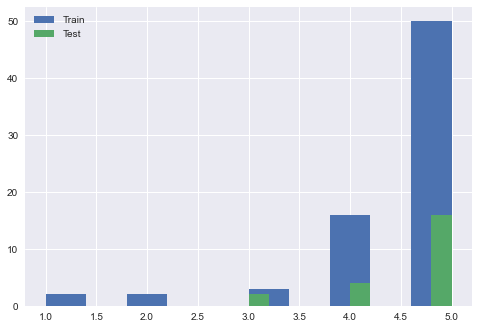

In [29]:
print("Количество образцов в обучающей выборке:", len(rankingsTrain))
print("Количество образцов в проверочной выборке:", len(rankingsTest))
print("Количество образцов в проверочной выборке в процентном соотношении: {:.1f}%"\
      .format(len(rankingsTest) / len(rankings) * 100))

rankingsTrain["rating"].hist(label="Train")
rankingsTest["rating"].hist(label="Test")
plt.legend()
plt.show()

Из гистограмм можно увидеть, что данные разделены не самым лучшим образом, а именно: в тестовой выборке нет ни 1, ни 2, но зато много 3. Но, так как это не научная работа, которая пойдёт в журнал, а учебная, то, полагаем, можно оставить такое разбиение.

### Визуализируем тренировочную и тестовую выборки

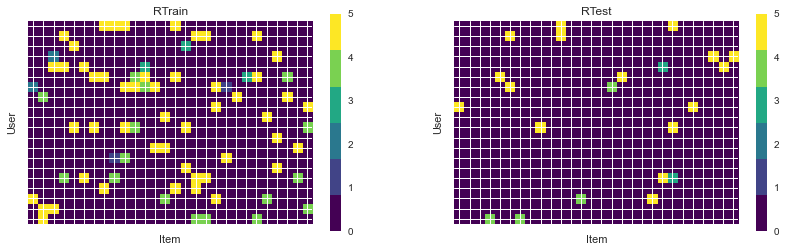

Заполненность матрицы RTrain: 13.04
Заполненность матрицы RTest: 3.93


In [30]:
RTrain = createR(rankingsTrain, userUniqList, itemUniqList)
RTest = createR(rankingsTest, userUniqList, itemUniqList)


fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))
plt.sca(axs[0]) 
visualizeR(RTrain, "Item", "User", itemUniqList, userUniqList, autoFigsize=False)
plt.title("RTrain")

plt.sca(axs[1]) 
visualizeR(RTest, "Item", "User", itemUniqList, userUniqList, autoFigsize=False)
plt.title("RTest")
plt.show()

print("Заполненность матрицы RTrain: {:.2f}"\
      .format((RTrain != 0).sum() / (RTrain.shape[0] * RTrain.shape[1]) * 100))
print("Заполненность матрицы RTest: {:.2f}"\
      .format((RTest != 0).sum() / (RTest.shape[0] * RTest.shape[1]) * 100))


### Получение предсказаний для RTrain и сравнение с RTest

*Замечание*: Среднеквадратичная ошибка считается для ненулевых предсказанных значений

In [31]:
def compareRTrainAndRTest(RTrain: np.ndarray, RTest: np.ndarray, xLabelsList, yLabelsList, isPlot=False):
    markersForPlot = iter(["x", "<", "^", "o", "*"])
    RTest = RTest.flat.copy() # Легче работать с одномерными массивами
    for simClass in [EuclideSim, ManhattanSim, PearsonSim, JaccardSim, CosinusSim]:
        display(Markdown("**{}**".format(simClass.__name__)))
        RSim = getRSim(RTrain, yLabelsList, simClass)
        RPredicted = getRatingsForAll(RTrain, RSim).flat.copy()
        print("Предсказано значений: {} / {}"\
              .format((RPredicted != 0).sum(), (RTrain == 0).sum() - (RTest != 0).sum()))
        # Занулим те значения, для которых не можем оценить качество предсказания
        RPredicted[RTest == 0] = 0
        print("Количество не предсказанных значений из тех, которые можем проверить:", 
              len(RPredicted[(RTest != 0) & (RPredicted == 0)]))
        print("Среднеквадратичная ошибка:{:.1f}".format(calculateError(RPredicted[RPredicted != 0], 
                                                                       RTest[RPredicted != 0])))
        if isPlot:
            plt.scatter(RTest[RTest != 0], RPredicted[RTest != 0], label=simClass.__name__,
                       marker=next(markersForPlot), s=80, alpha=0.7)
        print("-+"*15, "\n")
    if isPlot:
        plt.plot( [0,5], [0,5], lw=2, color='gray', linestyle='dashed',) # график проверочный
        plt.legend(loc="lower left")  # отобразить легенду
        plt.xlabel('Реальные(проверочные)') # посдпись оси X
        plt.ylabel('Вычисленные')           # посдпись оси Y
        plt.xlim([-0.1,5.1]) # диапазон значений X
        plt.ylim([-0.1,5.1]) # диапазон значений Y

#### User-based

**EuclideSim**


Предсказано значений: 188 / 465
Количество не предсказанных значений из тех, которые можем проверить: 8
Среднеквадратичная ошибка:6.7
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+ 



**ManhattanSim**


Предсказано значений: 185 / 465
Количество не предсказанных значений из тех, которые можем проверить: 8
Среднеквадратичная ошибка:6.6
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+ 



**PearsonSim**


Предсказано значений: 175 / 465
Количество не предсказанных значений из тех, которые можем проверить: 8
Среднеквадратичная ошибка:6.6
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+ 



**JaccardSim**


Предсказано значений: 199 / 465
Количество не предсказанных значений из тех, которые можем проверить: 6
Среднеквадратичная ошибка:7.0
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+ 



**CosinusSim**


Предсказано значений: 199 / 465
Количество не предсказанных значений из тех, которые можем проверить: 6
Среднеквадратичная ошибка:7.0
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+ 



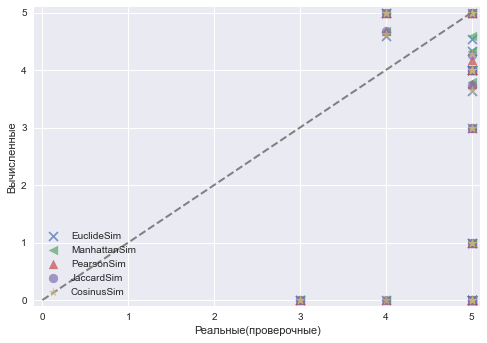

In [32]:
compareRTrainAndRTest(RTrain, RTest, itemUniqList, userUniqList, isPlot=True)

#### Item-based

**EuclideSim**


Предсказано значений: 139 / 465
Количество не предсказанных значений из тех, которые можем проверить: 9
Среднеквадратичная ошибка:3.4
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+ 



**ManhattanSim**


Предсказано значений: 134 / 465
Количество не предсказанных значений из тех, которые можем проверить: 10
Среднеквадратичная ошибка:3.4
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+ 



**PearsonSim**


Предсказано значений: 147 / 465
Количество не предсказанных значений из тех, которые можем проверить: 7
Среднеквадратичная ошибка:3.2
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+ 



**JaccardSim**


Предсказано значений: 148 / 465
Количество не предсказанных значений из тех, которые можем проверить: 8
Среднеквадратичная ошибка:3.3
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+ 



**CosinusSim**


Предсказано значений: 147 / 465
Количество не предсказанных значений из тех, которые можем проверить: 7
Среднеквадратичная ошибка:3.2
-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+ 



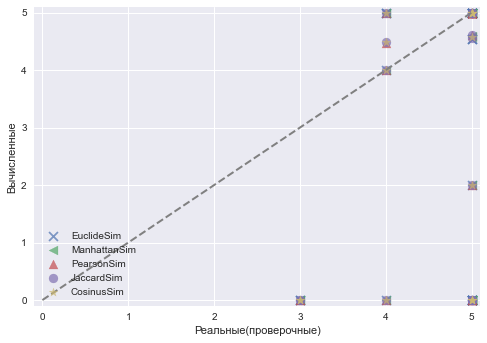

In [33]:
compareRTrainAndRTest(RTrain.T, RTest.T, userUniqList, itemUniqList, isPlot=True)

### Выводы по оценке качества предсказаний по методам user-based и item-based

Из общего количества оценок (95) было выделено 23.2% под тестовый набор данных для проведения оценки качества предсказаний по методам коллаборативной фильтрации методами user-based и item-based для 5 функций схожести (EuclideSim, ManhattanSim, PearsonSim, JaccardSim, CosinusSim).

~~Можно отметить общую тенденцию: чем меньше алгоритм отвечает, тем лучше его среднеквадратичная ошибка.~~ (Данная тенденция не видна для item-based. Но она наблюдалась неоднократно, пока не был введён "ритуал с сортировкой", позволивший однозначно разбить выборку на train и test).

При одинаковом количестве непредсказанных значений алгоритмы имеют примерно одинаковые результаты (внутри item-based и user-based по отдельности).
Поэтому будем сравнивать отдельно алгоритмы на основе различных методов схожести по общему количеству предсказанных значений и количеству значений, в которых алгоритм воздержался. Также отдельно сравним user-based и item-based.

В user-based алгоритме коллаборативной фильтрации наиболее "воздержанным" от предсказаний оказался алгоритм с PearsonSim. Но на тестовой выборке он показал одинаковые результаты с EuclideSim и ManhattanSim. Алгоритмы с JaccardSim и CosinusSim имеют наибольшее количество предсказанных значений. 

В item-based алгоритм с ManhattanSim показал наихудший результат (наименьшее кол-во предсказанных значений, наибольшее кол-во непредсказанных значений из те, которые можно проверить и, при этом, наибольшая среднеквадратичная ошибка). алгоритм с EuclideSim оказался не на много лучше. Алгоритмы с PearsonSim, JaccardSim, CosinusSim показывают примерно одинаковый результат.

Напомним, что в таблице R имеется 20 пользователей и 28 товаров. В методичке указывалось, что в таком случае (когда товаров больше, чем пользователей) предпочтительнее использовать user-based алгоритм. User-based алгоритмы предсказали большее количество значений, при этом результаты с разными функциями близости примерно одинаковые. Не смотря на это, среднеквадратичная ошибка для user-based оказалась больше по сравнению с item-based. Если посмотрим на изображения, то увидем, что есть случаи, где оценка должна быть 5, но алгоритмы user-based предсказали 1, также частая ошибка - это вместо 5 предсказывать 4. Item-based алгоритмы хоть и предсказали меньшее количество значений, но они имеют лучшее соответствие предсказанных значений истиным.

# Выводы

Проведены анализ и предобработка имеющихся данных. Получена матрица оценок R, реализованы методы описания и визуализации данной матрицы. Реализованы функции схожести для всех 5 представленных в задании методов. Реализованы методы коллаборативной фильтрации user-based и item-based для 5 функций схожести (EuclideSim, ManhattanSim, PearsonSim, JaccardSim, CosinusSim), проведена оценка качества полученных алгоритмов